In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../dataset/tmp.csv')
df.head()

,Date,Prev Close,Open,High,Low,Close,VWAP,Volume
0,2020-01-01,64.35,64.50,65.05,63.95,64.70,64.47,8568946
1,2020-01-02,64.70,65.00,67.00,64.55,66.70,66.16,26059066
2,2020-01-03,66.70,66.55,66.55,64.60,65.05,65.46,14906983
3,2020-01-06,65.05,64.90,64.90,61.00,61.40,61.96,24078755
4,2020-01-07,61.40,62.10,63.10,61.00,61.85,61.99,20436567


In [3]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,64.700000,64.700000,NaN
1,0.0,65.700000,65.700000,0.0
2,0.0,65.483333,65.483333,0.0
3,0.0,64.462500,64.462500,0.0
4,0.0,63.940000,63.940000,0.0
...,...,...,...,...
294,1.0,41.557143,41.239286,0.0
295,1.0,41.928571,41.582143,0.0
296,1.0,41.914286,41.735714,0.0
297,0.0,41.892857,41.896429,-1.0


In [4]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [5]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 16: buy 1 units at price 61.800000, total balance 9938.200000
day 17, sell 1 units at price 62.350000, investment 0.889968 %, total balance 10000.550000,
day 74: buy 1 units at price 31.100000, total balance 9969.450000
day 80, sell 1 units at price 32.300000, investment 3.858521 %, total balance 10001.750000,
day 103: buy 1 units at price 30.250000, total balance 9971.500000
day 132, sell 1 units at price 33.550000, investment 10.909091 %, total balance 10005.050000,
day 152: buy 1 units at price 32.850000, total balance 9972.200000
day 171, sell 1 units at price 33.800000, investment 2.891933 %, total balance 10006.000000,
day 214: buy 1 units at price 27.750000, total balance 9978.250000
day 245, sell 1 units at price 33.400000, investment 20.360360 %, total balance 10011.650000,
day 255: buy 1 units at price 35.200000, total balance 9976.450000
day 268, sell 1 units at price 34.150000, investment -2.982955 %, total balance 10010.600000,
day 275: buy 1 units at price 40.500000, 

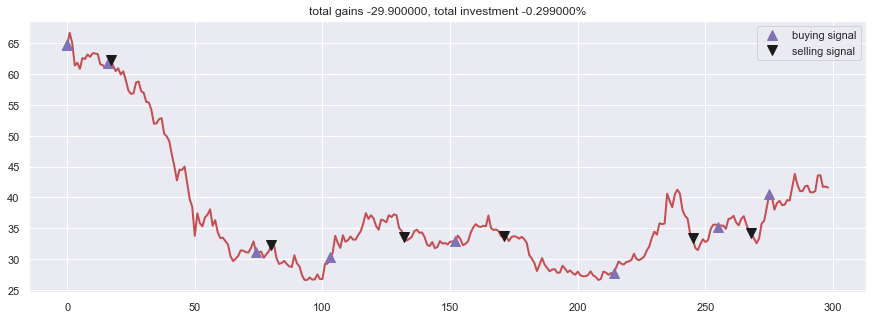

In [6]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()